<a href="https://colab.research.google.com/github/Minh-A/Dacon_ArcticSeaIce_Prediction_2/blob/main/Code_2_ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(/^▽^)/   코드공유입니다!

# 앙상블 모델 만들기

> 앙상블
* https://huidea.tistory.com/35

## 함수

In [ ]:
# 그림을 그리는 함수
# 코드공유 - 'DATA loading + Simple EDA + 참고가능 논문' 내의 함수를 약간 변경하였습니다.
# 코드 공유를 해주신 Jay윤님 감사합니다.

def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛 모양
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 둘째 자리에서 반올림하는 함수

def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 점수 계산
# 대회안내 - 규칙에 존재하는 산식 코드입니다.

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor  # 사용할 모델입니다.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# 제출 데이터
fn1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/public_weekly_test.csv')
dm1 = fn1.iloc[1:,1]
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12150.npy')
data = data.reshape(1,448,304,5)

#
for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)
    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

print(data.shape)

#
inference = data

100%|██████████| 23/23 [00:18<00:00,  1.23it/s]

(24, 448, 304)


In [ ]:
# 1차 데이터 불러오기
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train.csv')
fn.tail()

week_start  ...                                          data_list
2169  2020-05-18  ...  20200518.npy,20200519.npy,20200520.npy,2020052...
2170  2020-05-25  ...  20200525.npy,20200526.npy,20200527.npy,2020052...
2171  2020-06-01  ...  20200601.npy,20200602.npy,20200603.npy,2020060...
2172  2020-06-08  ...  20200608.npy,20200609.npy,20200610.npy,2020061...
2173  2020-06-15  ...  20200615.npy,20200616.npy,20200617.npy,2020061...

[5 rows x 3 columns]

데이터 전처리

In [ ]:
def filemake(num,iii):
  dm = fn.iloc[num:num+37,1]

  start = fn.iloc[num-1,1]
  data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/{}'.format(start))
  data = data.reshape(1,448,304,5)

  for i in dm:
     a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
     a = a.reshape(1,448,304,5)
     data = np.concatenate((data,a), axis=0)

  data = np.array(data)
  data = data[:,:,:,0]


  # train 데이터 셋
  globals()['train{}'.format(iii)] = data[:24]  # 1월부터 6월

  # 데이터 셋 형태 변환
  data = data.reshape(38,1,448,304)

  # test 데이터 생성
  globals()['test{}'.format(iii)] = np.array(np.concatenate((data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37]), axis=0))  # 7월부터 9월
  
  globals()['train{}'.format(iii)] =   globals()['train{}'.format(iii)].reshape(24,448,304)

  print(globals()['train{}'.format(iii)].shape, globals()['test{}'.format(iii)].shape)

In [ ]:
lis = [2099, 2045, 1993, 1941, 1889, 1837] # 2019년~2014년
# lis = [2099, 2045, 1993, 1941, 1889, 1837, 1785, 1732, 1680, 1628, 1576, 1524] # 2019년~2008년

for i,datan in tqdm(enumerate(lis)):
  filemake(datan, i)

1it [00:31, 31.14s/it]

(24, 448, 304) (12, 448, 304)


2it [01:00, 30.49s/it]

(24, 448, 304) (12, 448, 304)


3it [01:31, 30.68s/it]

(24, 448, 304) (12, 448, 304)


4it [02:03, 31.07s/it]

(24, 448, 304) (12, 448, 304)


5it [02:32, 30.45s/it]

(24, 448, 304) (12, 448, 304)


6it [02:58, 29.79s/it]

(24, 448, 304) (12, 448, 304)


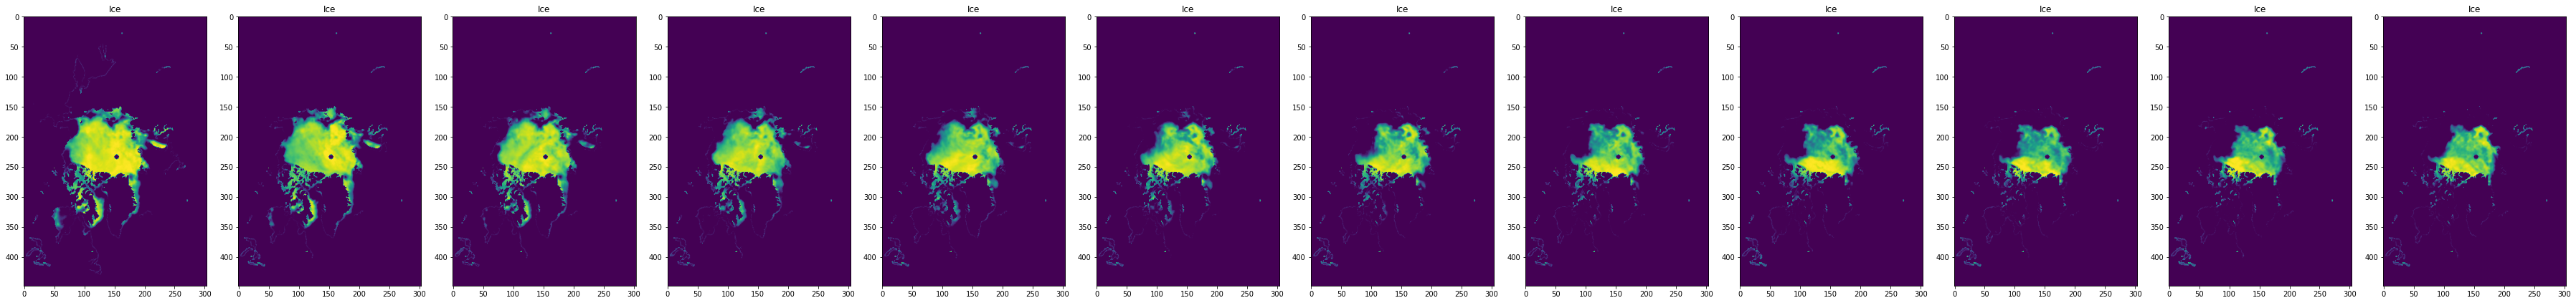

In [ ]:
show(test2)

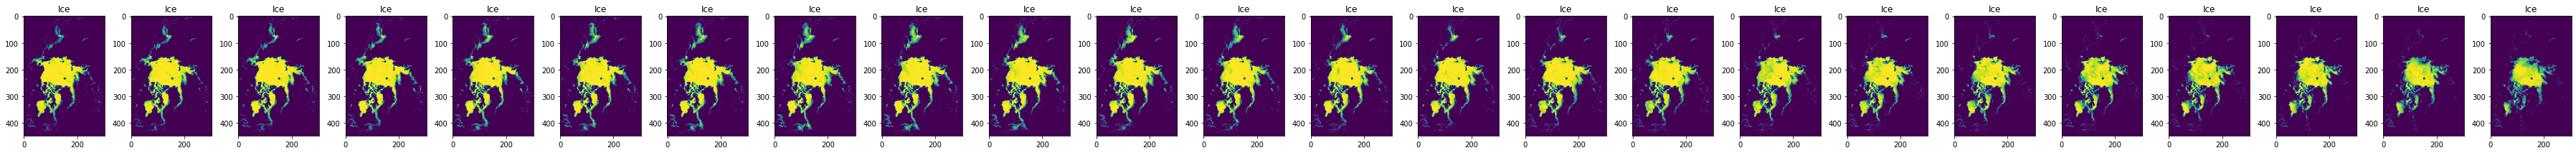

In [ ]:
show(train0)

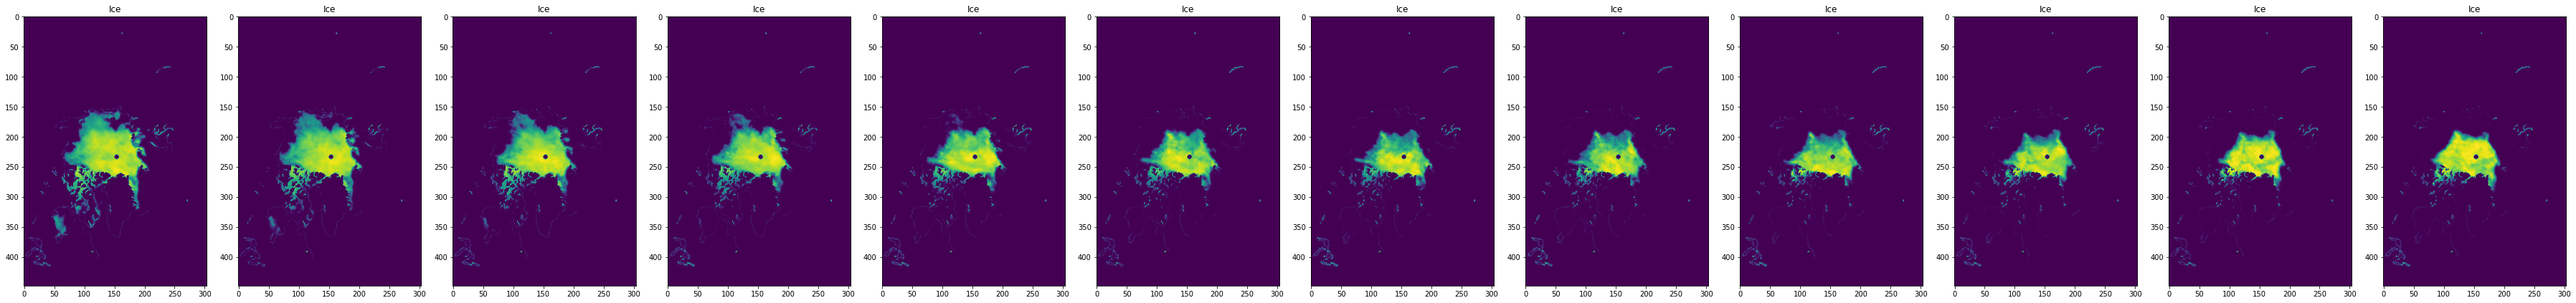

In [ ]:
show(test0)

# tabnet

In [ ]:
train0.shape, test0.shape

((24, 448, 304), (12, 448, 304))

In [ ]:
test0[11].reshape(136192).shape

(136192,)

In [ ]:
# 모델 학습
from sklearn.svm import SVR
model = SVR(gamma=0.01).fit(train0.reshape(24,-1), test0[11].reshape(-1))

ValueError: ignored

* https://deep-deep-deep.tistory.com/32
* !!!!!

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers 
import numpy as np 
import pylab as plt

In [ ]:
train0[0].shape

(448, 304)

In [ ]:
seq = keras.Sequential(
     [ keras.Input( 
         shape=(None, 448, 304, 1) 
         # (time, rows, cols, channels) 
         # 이 중, time을 지정하지 가변으로 두고, (None, 40,40,1) shape의 프레임을 입력받습니다. 
         ), # 40x40에 1채널을 가지는 프레임입니다. 
      layers.ConvLSTM2D( filters=1, kernel_size=(100, 100), padding="same", return_sequences=True ),]
      ) 

seq.compile(loss="mean_absolute_error", optimizer="Adam")

In [ ]:
seq.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 448, 304, 1) 80004     
Total params: 80,004
Trainable params: 80,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test0.shape

(12, 448, 304)

In [ ]:
train0[12:].shape

(12, 448, 304)

In [ ]:
aa = train0[12:].reshape(1,12,448,304,1)

In [ ]:
aa.shape

(1, 12, 448, 304, 1)

In [ ]:
bb = test0.reshape(1,12,448,304,1)
bb.shape

(1, 12, 448, 304, 1)

In [ ]:
seq.fit( aa,bb, 
        batch_size=1, epochs=50)

Epoch 1/50


In [ ]:
seq.predict(aa)

array([[[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         ...,

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],


In [ ]:
seq.predict(aa).shape

(1, 12, 448, 304, 1)

In [ ]:
aaa = seq.predict(aa).reshape(12,448,304)

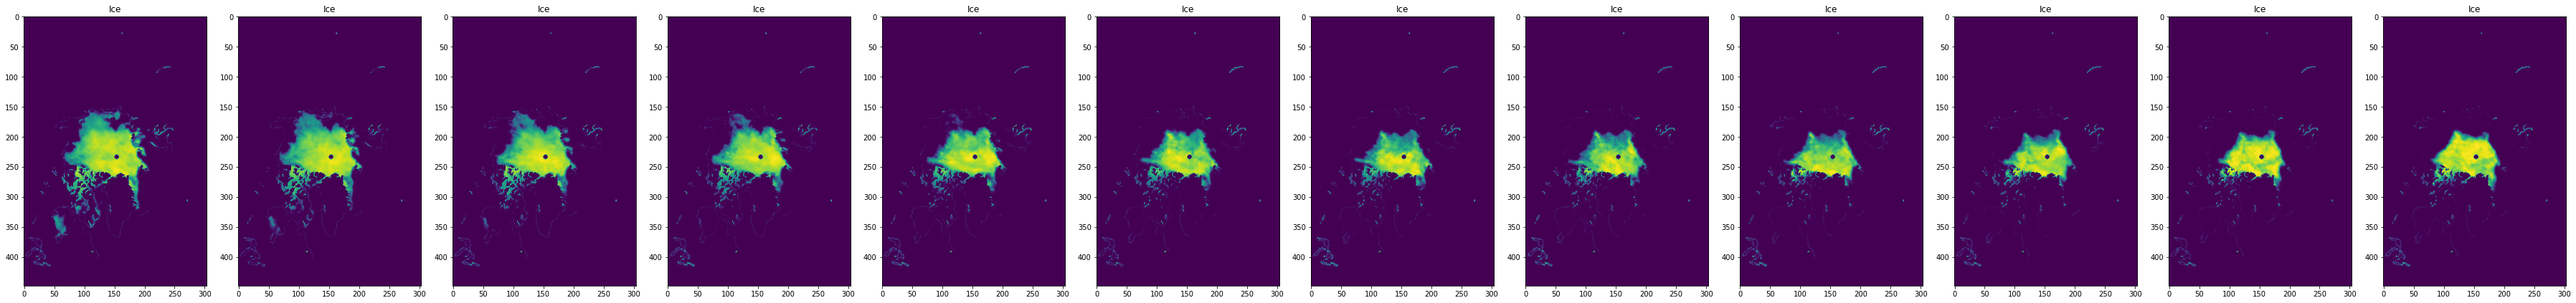

In [ ]:
show(test0)

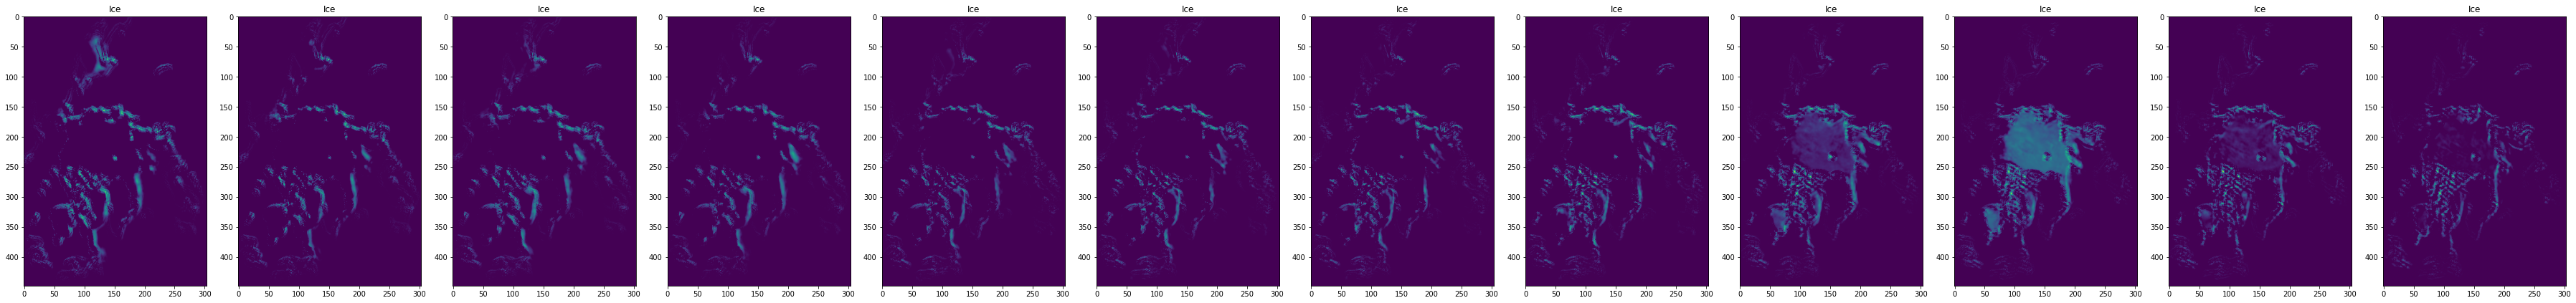

In [ ]:
show(fun1(aaa))

In [ ]:
pochs = 1 
# 예제이기 때문에 에폭을 1로 지정했습니다. 
# 실제로 모델의 정확도를 높이려면 수백번 이상으로 설정하세요! 

noisy_movies, shifted_movies = generate_movies(n_samples=1200) 

seq.fit( noisy_movies[:1000], shifted_movies[:1000], 
        batch_size=10, epochs=epochs, verbose=2, validation_split=0.1, )


In [ ]:
movie_index = 1004 
test_movie = noisy_movies[movie_index] 

# 1004번째 영상의 프레임 중 앞의 7개의 프레임을 test set으로 선정합니다. 
track = test_movie[:7, ::, ::, ::] 

# Predict 16 frames 
# 앞으로의 16개의 프레임을 예측해 봅시다. 

for j in range(16): 
  
  # 모델의 input shape에 맞추기 위해 np.newaxis를 붙여줬습니다. 
  # 영상 축을 추가한 것입니다. 
  # (프레임, 세로, 가로, 채널)에서 (영상, 프레임, 세로, 가로, 채널)로 바꿔주었습니다. 
  new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::]) 
  
  # test set에서 마지막 프레임에 추가하기 위해서 -1을 적어줬습니다. 
  new = new_pos[::, -1, ::, ::, ::] 
  track = np.concatenate((track, new), axis=0) 
  # 처음에는 7프레임으로 예측했고, 
  # 그 다음은 예측한 프레임을 더한 8프레임으로 예측하고, 
  # 16번의 프레임이 더해질 때까지 반복합니다.


# z

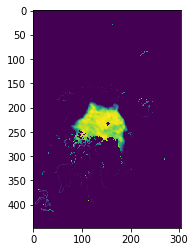

In [ ]:
plt.imshow(test0[11], interpolation = 'None')
plt.show()

In [ ]:
bb = test0[11].reshape(1,448,304)
abc = np.array(np.concatenate((bb,bb,bb,bb,bb,bb,bb,bb,bb,bb,bb,bb), axis=0))
abc.shape

(12, 448, 304)

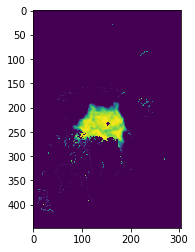

In [ ]:
plt.imshow(test0[10], interpolation = 'None')
plt.show()

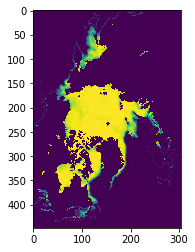

In [ ]:
plt.imshow(train0[10], interpolation = 'None')
plt.show()

In [ ]:
bb = train0[10].reshape(1,448,304)
abc2 = np.array(np.concatenate((bb,bb,bb,bb,bb,bb,bb,bb,bb,bb,bb,bb), axis=0))
abc2.shape

(12, 448, 304)

In [ ]:
test0.shape

(12, 448, 304)

  0%|          | 0/1 [00:00<?, ?it/s]

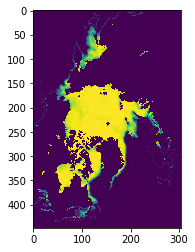

100%|██████████| 1/1 [06:13<00:00, 373.58s/it]


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(1)):
  # 데이터셋 나누기
  x_train = abc.reshape(12,-1).T
  y_train = abc[0].reshape(-1).T
  x_test = abc2.reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=600, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

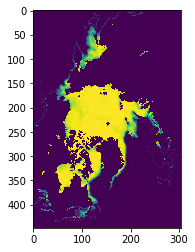

In [ ]:
plt.imshow(predictions.reshape(448,304), interpolation = 'None')
plt.show()

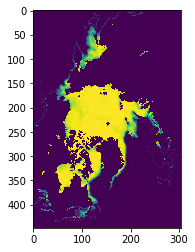

In [ ]:
plt.imshow(train0[10], interpolation = 'None')
plt.show()

In [ ]:
predictions.shape

(136192,)

In [ ]:
train0[10].reshape(-1).shape

(136192,)

In [ ]:
real = train0[10].reshape(-1)

print( "MAE : %s" % mae_score(real, fun1(predictions)),
        '\n F1 : %s' % f1_score(real, fun1(predictions)),
        '\n Final %s' % mae_over_f1(real, fun1(predictions)))

MAE : 0.0 
 F1 : 0.999999977945522 
 Final 0.0


In [ ]:
data = np.concatenate((data,a), axis=0)

data = np.array(data)

일단 3개로 12개의 모델 만들기

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(1)):
  tr = globals()['train{}'.format(i)]
  te = globals()['test{}'.format(i)][11]

  # 데이터셋 나누기
  x_train = tr.reshape(24,-1).T
  y_train = te.reshape(1,-1).T
  x_test = tr.reshape(24,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=600, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()






  0%|          | 0/1 [00:00<?, ?it/s]






100%|██████████| 1/1 [13:15<00:00, 795.36s/it]


In [ ]:
real = test111.reshape(12,-1)[11]

print( "MAE : %s" % mae_score(real, fun1(predictions)),
        '\n F1 : %s' % f1_score(real, fun1(predictions)),
        '\n Final %s' % mae_over_f1(real, fun1(predictions)))

MAE : 2.936491644149436 
 F1 : 0.7587738593563333 
 Final 3.870048459418426


> 모델 구성법
* 1) 24개의 훈련 데이터로 12개의 테스트 데이터를 각각 훈련시킴
* 2) 12개의 주별 모델을 만들어 1)에서 만들어진 예측 값을 추가하여 훈련

In [ ]:
# 돈 터치
real = test111.reshape(12,-1)[11]

print( "MAE : %s" % mae_score(real, fun1(predictions)),
        '\n F1 : %s' % f1_score(real, fun1(predictions)),
        '\n Final %s' % mae_over_f1(real, fun1(predictions)))

MAE : 0.008798387570488722 
 F1 : 0.9999999780327871 
 Final 0.0087983876757809


In [ ]:
sub = np.zeros((24, 136192))
for i,recent_n_year in enumerate([5]):
  print('Recent_n_year:', recent_n_year)

  valid_errors = []
  for infer_year in [42, 41, 40, 39, 38, 37, 36]:

    pred_ = np.zeros((24, 136192))
    true_ = np.zeros((12, 136192))


    for m in range(12):

      train_month = train[train['m'] == m+1]
      img_month = data[train_month.index.values][:,:,:,0]

      if infer_year < 42:
        true_img = img_month[41-1]                   40을 선택
        true_[m] += true_img.reshape(-1)             40을 펴서 넣음
      pred_[m] += np.mean(img_month[41-1-5:41-1,:,:], axis=0).reshape(-1)
    
    if infer_year == 42:
      sub[12:] += pred_[:12]
      
    else:
      valid_errors.append(mae_over_f1(true_, pred_[:12]))    
      if infer_year == 41:
        sub[:12] += pred_[:12]
  
  # pd.DataFrame(data=sub).set_index(sample_submission['month']).to_csv(f'../submissions/submission{i+2}_FINAL.csv')
  print(valid_errors)
  print('MEAN of ERRORS:', np.mean(valid_errors))
  print('STD of ERRORS:', np.std(valid_errors))
  print('\n')

In [ ]:
test0[11].shape

(448, 304)

In [ ]:
# 찾아봥

# 기본
import lightgbm as lgb

for i in tqdm(range(1)):
  tr = globals()['train{}'.format(i)]
  te = globals()['test{}'.format(i)][11]

  # 데이터셋 나누기
  x_train = tr.reshape(24,-1).T
  y_train = te.reshape(1,-1).T
  x_test = tr.reshape(24,-1).T

  x_train = pd.DataFrame(x_train)
  y_train = pd.DataFrame(y_train)
  x_test = pd.DataFrame(x_test)

  # 데이터셋 변환
  train_ds = lgb.Dataset(x_train, label = y_train) 

  # 파라미터
  params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

  # 모델 훈련
  model = lgb.train(params, train_ds, 1000)

  # 모델 예측
  predictions1 = model.predict(x_test)
  predictions1 = predictions1.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions1.reshape(448,304), interpolation = 'None')
  plt.show()






  0%|          | 0/1 [00:00<?, ?it/s]






100%|██████████| 1/1 [00:50<00:00, 50.75s/it]


In [ ]:
real = test111.reshape(12,-1)[11]

print( "MAE : %s" % mae_score(real, fun1(predictions1)),
        '\n F1 : %s' % f1_score(real, fun1(predictions1)),
        '\n Final %s' % mae_over_f1(real, fun1(predictions1)))

MAE : 3.314373237781955 
 F1 : 0.7296803465680033 
 Final 4.542226206240305


In [ ]:
real = test111.reshape(12,-1)[11]

print( "MAE : %s" % mae_score(real, fun1(predictions1)),
        '\n F1 : %s' % f1_score(real, fun1(predictions1)),
        '\n Final %s' % mae_over_f1(real, fun1(predictions1)))

MAE : 0.9502213052161655 
 F1 : 0.907053921327732 
 Final 1.0475907466993124


KNNR 모델

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(1)):
  tr = globals()['train{}'.format(i)]
  te = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = tr.reshape(24,-1).T
  y_train = te.reshape(12,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=1200, weights='distance', p=1, n_jobs=-1) #601
  globals()['model{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions = globals()['model{}'.format(i)].predict(x_test)
  predictions = predictions.reshape(12,-1)

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

In [ ]:
pred_0.shape

(12, 136192)

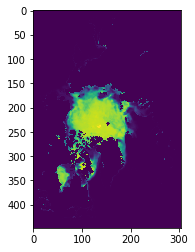

In [ ]:
plt.imshow(pred_0.reshape(448*304, 12).T[0].reshape(448,304), interpolation = 'None')
plt.show()

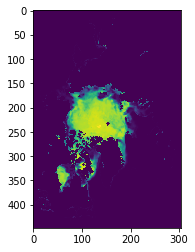

In [ ]:
plt.imshow(pred_0.reshape(448*304, 12)[:,0].reshape(448,304), interpolation = 'None')
plt.show()

In [ ]:
# 그래프를 보자구
for j in tqdm(range(12)):
  print(j)
  show(globals()['pred_{}'.format(j)].reshape(448*304, 12).T.reshape(12,448,304))

앙상블 합치기

In [ ]:
aa = (pred_0 + pred_1 + pred_2 + pred_3 + pred_4 + pred_5 + pred_6 + pred_7 + pred_8 + pred_9 + pred_10 + pred_11)/12
aa.shape

(12, 136192)

In [ ]:
# aa3_new = (pred_0 + pred_1 + pred_2)/3
aa3_new = (pred_0 * pred_1 * pred_2)**(1/3)
aa3_new.shape

(12, 136192)

In [ ]:
aa3_2016 = (pred_3 + pred_4 + pred_5)/3
aa3_2016.shape

(12, 136192)

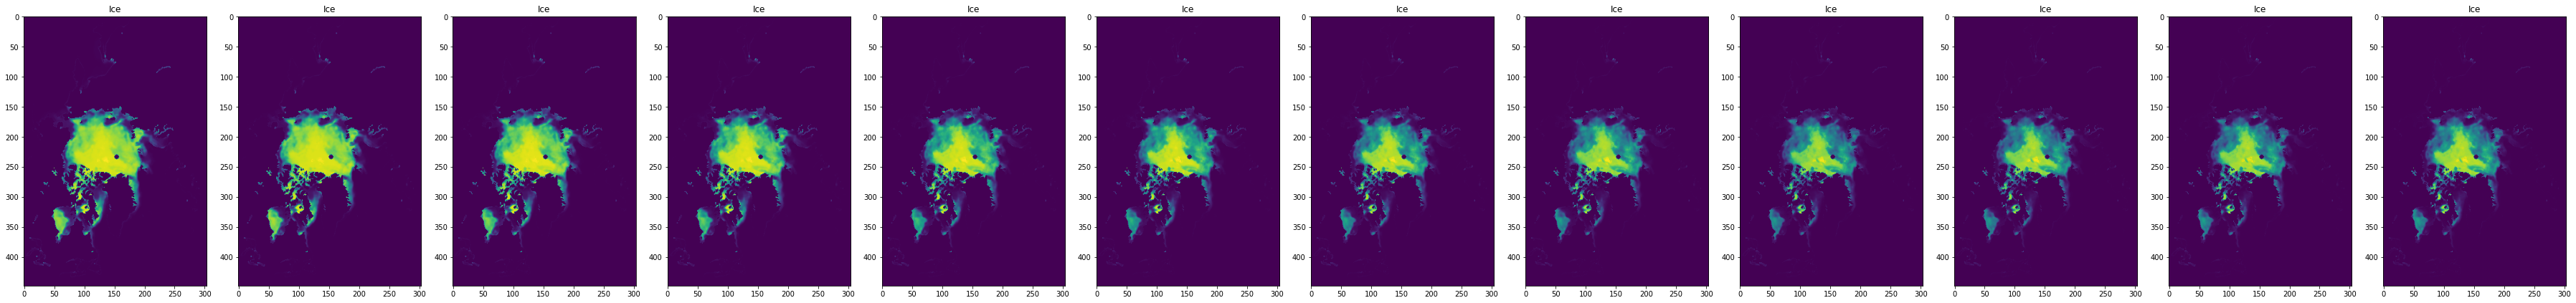

In [ ]:
show(aa3_new.reshape(448*304, 12).T.reshape(12,448,304))

제출

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(aa3_new.reshape(448*304, 12)).T  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

# 1차 데이터 확인 (Pre-제출본)
sh2

0       1       2       3       ...  136188  136189  136190  136191
0      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
1      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
2      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
3      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
4      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
5      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
6      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
7      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
8      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
9      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
10     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
11     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[12 rows x 136192 columns]

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([sh2,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

week_start    0    1    2    3  ...  136187  136188  136189  136190  136191
19  2021-08-24  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
20  2021-08-31  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
21  2021-09-07  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
22  2021-09-14  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
23  2021-09-21  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0

[5 rows x 136193 columns]

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

Text(0.5, 1.0, 'Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/result/sub_0516_2_KNN(3models,1200_제곱근).csv', index = False)

# 테스팅용

In [ ]:
# 테스트 파일 정하기
# test = 2099
filemake(2099, 111)  # 테스트 파일 이름은 test000가 리얼, 사용할 데이터는 train000 


# 훈련데이터 파일 정하기
lis = [2045, 1993, 1941, 1889, 1837, 1785, 1732] # 2019년~2012년
# lis = [2099, 2045, 1993, 1941, 1889, 1837, 1785, 1732, 1680, 1628, 1576, 1524] # 2019년~2008년

for i,datan in tqdm(enumerate(lis)):
  filemake(datan, i)

In [ ]:
# 일단은 모델 1개에서 K개수 찾기

num = [100]

for j in tqdm(num):
  print('\n', j)
  
  for i in tqdm(range(1)):
    tr = globals()['train{}'.format(i)]
    te = globals()['test{}'.format(i)]

    # 데이터셋 나누기
    x_train = tr.reshape(24,-1).T
    y_train = te.reshape(12,-1).T
    x_test = train111.reshape(24,-1).T

    # 모델 훈련
    globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=j, weights='distance', p=2, n_jobs=-1) #601
    globals()['model{}'.format(i)].fit(x_train, y_train)

    # 모델 예측
    predictions = globals()['model{}'.format(i)].predict(x_test)
    predictions = predictions.reshape(12,-1)

    # 변수 저장
    globals()['pred_{}'.format(i)] = predictions
    print(globals()['pred_{}'.format(i)].shape)

  # aa3_new = (pred_0 + pred_1 + pred_2)/3  # 앙상블 평균
  aa3_new = pred_0
  aa3_new = aa3_new.reshape(448*304, 12).T
  real = test111.reshape(12,-1)

  print( "MAE : %s" % mae_score(real, fun1(a)),
         '\n F1 : %s' % f1_score(real, fun1(a)),
         '\n Final %s' % mae_over_f1(real, fun1(a)))







  0%|          | 0/1 [00:00<?, ?it/s]





  0%|          | 0/1 [00:00<?, ?it/s]


 100








100%|██████████| 1/1 [19:15<00:00, 1155.46s/it]





100%|██████████| 1/1 [19:15<00:00, 1155.58s/it]

(12, 136192)
MAE : 6.656566789287671 
 F1 : 0.7580584055476459 
 Final 8.781073664987614


In [ ]:
# 일단은 모델 3개에서 K개수 찾기

num = [300, 600, 1000, 1500, 2000]

for j in tqdm(num):
  print(j)
  
  for i in tqdm(range(3)):
    tr = globals()['train{}'.format(i)]
    te = globals()['test{}'.format(i)]

    # 데이터셋 나누기
    x_train = tr.reshape(24,-1).T
    y_train = te.reshape(12,-1).T
    x_test = train111.reshape(24,-1).T

    # 모델 훈련
    globals()['model{}'.format(i)] = KNeighborsRegressor(n_neighbors=j, weights='distance', p=1, n_jobs=-1) #601
    globals()['model{}'.format(i)].fit(x_train, y_train)

    # 모델 예측
    predictions = globals()['model{}'.format(i)].predict(x_test)
    predictions = predictions.reshape(12,-1)

    # 변수 저장
    globals()['pred_{}'.format(i)] = predictions
    print(globals()['pred_{}'.format(i)].shape)

  aa3_new = (pred_0 + pred_1 + pred_2)/3  # 앙상블 평균
  aa3_new = aa3_new.reshape(448*304, 12).T
  real = test111.reshape(12,-1)

  print( "MAE : %s" % mae_score(real, fun1(a)),
         '\n F1 : %s' % f1_score(real, fun1(a)),
         '\n Final %s' % mae_over_f1(real, fun1(a)))


In [ ]:
예측은 12, 136192
리얼은? 12, 136192

In [ ]:
aa3_new.shape

(12, 136192)

In [ ]:
pred_0.shape

(12, 136192)

In [ ]:
real = test111
a = three.reshape(448*304, 12).T

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 6.656566789287671 
 F1 : 0.7580584055476459 
 Final 8.781073664987614


In [ ]:
real = test111
a = aa3_new.reshape(448*304, 12).T

print( "MAE : %s" % mae_score(real.reshape(12,-1), fun1(a)),
       '\n F1 : %s' % f1_score(real.reshape(12,-1), fun1(a)),
       '\n Final %s' % mae_over_f1(real.reshape(12,-1), fun1(a)))

MAE : 6.7586561618891 
 F1 : 0.7605099150731887 
 Final 8.887005861545688


In [ ]:
# 3제곱근
three = (pred_0 * pred_1 * pred_2)**(1/3)

In [ ]:
2**(1/3)

1.2599210498948732

In [ ]:
aa3_new.reshape(448*304, 12).T.shape

(12, 136192)

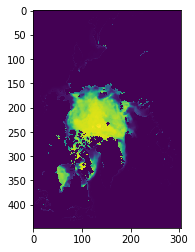

In [ ]:
plt.imshow(aa3_new.reshape(448*304, 12).T[0].reshape(448,304), interpolation = 'None')
plt.show()

In [ ]:
plt.imshow(aa3_new.reshape(448*304, 12).T[0].reshape(448,304), interpolation = 'None')
plt.show()

In [ ]:
filemake(2099, 111)

(24, 448, 304) (12, 448, 304)


In [ ]:
train111

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(3)):
  tr = globals()['train{}'.format(i)]
  te = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = tr.reshape(24,-1).T
  y_train = te.reshape(12,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  globals()['model_{}'.format(i)] = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) #601
  globals()['model_{}'.format(i)].fit(x_train, y_train)

  # 모델 예측
  predictions1 = globals()['model_{}'.format(i)].kneighbors_graph(x_train)

  # 변수 저장
  globals()['pred_gr{}'.format(i)] = predictions1
  print(globals()['pred_gr{}'.format(i)].shape)


 17%|█▋        | 1/6 [12:40<1:03:21, 760.31s/it]

(136192, 136192)


 33%|███▎      | 2/6 [25:29<50:51, 762.85s/it]  

(136192, 136192)


 50%|█████     | 3/6 [37:46<37:46, 755.34s/it]

(136192, 136192)


 67%|██████▋   | 4/6 [50:01<24:58, 749.18s/it]

(136192, 136192)


 83%|████████▎ | 5/6 [1:02:12<12:23, 743.60s/it]

(136192, 136192)


100%|██████████| 6/6 [1:14:17<00:00, 742.98s/it]

(136192, 136192)


In [ ]:
te.reshape(12,-1).T[:,0].shape

(136192,)

In [ ]:
train0[0:3].shape

(3, 448, 304)

In [ ]:
# from sklearn.ensemble import VotingRegressor  # <- 시간이 너무 오래 걸림 ㅜㅠ
from sklearn.ensemble import BaggingRegressor

# 배깅: 복원추출한 데이터에 대하여 여러모델의 만들어 평균
# 부스팅: 여러 모델을 만들어 최고분류 -> 중분류 -> 하분류 식의 모델을 생성

# 데이터에 차이가 있어도 되는지 확인

###########
from sklearn.neighbors import KNeighborsRegressor
model0 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
# model1 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
# model2 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
# model3 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
# model4 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)
# model5 = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1)


tr = train0
te = test0
#
x_train = tr.reshape(24,-1).T
y_train = te.reshape(12,-1).T

x_test = inference.reshape(24,-1).T
#


# final_model = VotingRegressor([('k0', model0), ('k1', model1), ('k2', model2), ('k3', model3), ('k4', model4), ('k5', model5)])
final_model = BaggingRegressor(base_estimator= model0)


print(x_train.shape, y_train.shape)
final_model.fit(x_train, y_train)


predictions = final_model.predict(x_test)
predictions = predictions.reshape(12,-1)


# 그래프를 보자구
for j in tqdm(range(12)):
  plt.imshow(predictions.reshape(448*304, 12)[:,j].reshape(448,304), interpolation = 'None')
  plt.show()

(136192, 3) (136192, 1)


ValueError: ignored

In [ ]:
 globals()['test{}'.format(i)]

In [ ]:
# 데이터 불러오기
# 2007부터
# 2000년도 데이터부터 불러옵니다.
dm = fn.iloc[2099:2099+37,1]
print(dm.shape,'\n', fn.iloc[2099:2136,0].head(), '\n', fn.iloc[2099:2136,0].tail())

(37,) 
 2099    2019-01-14
2100    2019-01-21
2101    2019-01-28
2102    2019-02-04
2103    2019-02-11
Name: week_start, dtype: object 
 2131    2019-08-26
2132    2019-09-02
2133    2019-09-09
2134    2019-09-16
2135    2019-09-23
Name: week_start, dtype: object


In [ ]:
fn.iloc[2045:,0]

2045    2018-01-01
2046    2018-01-08
2047    2018-01-15
2048    2018-01-22
2049    2018-01-29
           ...    
2169    2020-05-18
2170    2020-05-25
2171    2020-06-01
2172    2020-06-08
2173    2020-06-15
Name: week_start, Length: 129, dtype: object

In [ ]:
fn.iloc[1993:,0]

1993    2017-01-02
1994    2017-01-09
1995    2017-01-16
1996    2017-01-23
1997    2017-01-30
           ...    
2169    2020-05-18
2170    2020-05-25
2171    2020-06-01
2172    2020-06-08
2173    2020-06-15
Name: week_start, Length: 181, dtype: object

In [ ]:
fn.iloc[1941:,0]

1941    2016-01-04
1942    2016-01-11
1943    2016-01-18
1944    2016-01-25
1945    2016-02-01
           ...    
2169    2020-05-18
2170    2020-05-25
2171    2020-06-01
2172    2020-06-08
2173    2020-06-15
Name: week_start, Length: 233, dtype: object

In [ ]:
fn.iloc[1889:,0]

1889    2015-01-05
1890    2015-01-12
1891    2015-01-19
1892    2015-01-26
1893    2015-02-02
           ...    
2169    2020-05-18
2170    2020-05-25
2171    2020-06-01
2172    2020-06-08
2173    2020-06-15
Name: week_start, Length: 285, dtype: object

In [ ]:
fn.iloc[1837:,0]

1837    2014-01-06
1838    2014-01-13
1839    2014-01-20
1840    2014-01-27
1841    2014-02-03
           ...    
2169    2020-05-18
2170    2020-05-25
2171    2020-06-01
2172    2020-06-08
2173    2020-06-15
Name: week_start, Length: 337, dtype: object

In [ ]:
# 데이터 생성
# 2000년도 이후 데이터들을 불러와 하나의 데이터 셋으로 만듭니다.
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12098.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape

100%|██████████| 37/37 [00:17<00:00,  2.14it/s]


(38, 448, 304)

In [ ]:
# train 데이터 셋
train = data[:24]

# 데이터 셋 형태 변환
data = data.reshape(38,1,448,304)

# test 데이터 생성
for i in range(1):
  globals()['test{}'.format(i)] = np.array(np.concatenate((data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37]), axis=0))

train = train.reshape(24,448,304)
train.shape, test0.shape

((24, 448, 304), (12, 448, 304))

추론 데이터

In [ ]:
# 1차 데이터 불러오기
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/public_weekly_test.csv')
fn.tail()

week_start week_file_nm                                          data_list
19  2020-05-18    12169.npy  20200518.npy,20200519.npy,20200520.npy,2020052...
20  2020-05-25    12170.npy  20200525.npy,20200526.npy,20200527.npy,2020052...
21  2020-06-01    12171.npy  20200601.npy,20200602.npy,20200603.npy,2020060...
22  2020-06-08    12172.npy  20200608.npy,20200609.npy,20200610.npy,2020061...
23  2020-06-15    12173.npy  20200615.npy,20200616.npy,20200617.npy,2020061...

In [ ]:
# 데이터 불러오기
# 2000년도 데이터부터 불러옵니다.
dm = fn.iloc[1:,1]
print(dm.shape,'\n', fn.iloc[1:,0].head(), '\n', fn.iloc[1:,0].tail())

(23,) 
 1    2020-01-13
2    2020-01-20
3    2020-01-27
4    2020-02-03
5    2020-02-10
Name: week_start, dtype: object 
 19    2020-05-18
20    2020-05-25
21    2020-06-01
22    2020-06-08
23    2020-06-15
Name: week_start, dtype: object


In [ ]:
# 데이터 생성
# 2000년도 이후 데이터들을 불러와 하나의 데이터 셋으로 만듭니다.
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12150.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape

100%|██████████| 23/23 [00:06<00:00,  3.61it/s]


(24, 448, 304)

In [ ]:
# train 데이터 셋
inference = data
print('\n inference :', inference.shape)


 inference : (24, 448, 304)


  0%|          | 0/12 [00:00<?, ?it/s]

(12, 136192)


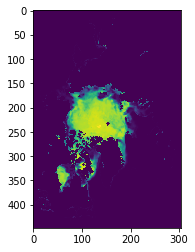

  8%|▊         | 1/12 [00:00<00:01,  6.90it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.67it/s]

 25%|██▌       | 3/12 [00:00<00:01,  7.02it/s]

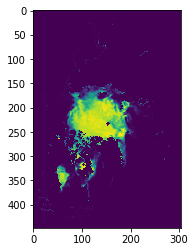

 33%|███▎      | 4/12 [00:00<00:01,  6.32it/s]

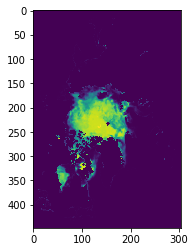

 42%|████▏     | 5/12 [00:00<00:01,  6.67it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.85it/s]

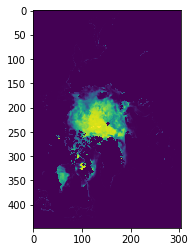

 58%|█████▊    | 7/12 [00:01<00:00,  7.19it/s]

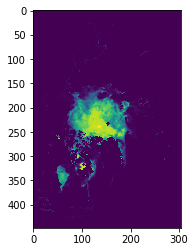

 67%|██████▋   | 8/12 [00:01<00:00,  7.27it/s]

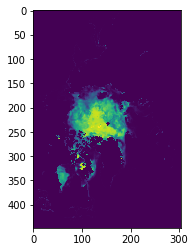

 75%|███████▌  | 9/12 [00:01<00:00,  7.34it/s]

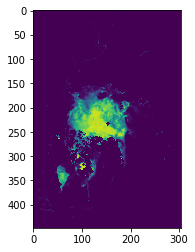

 83%|████████▎ | 10/12 [00:01<00:00,  7.27it/s]

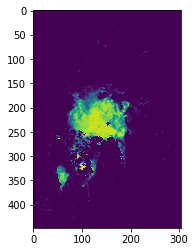

 92%|█████████▏| 11/12 [00:01<00:00,  7.36it/s]

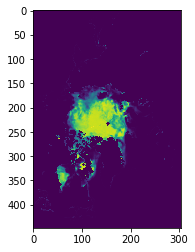

100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(1)):
  datan = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = train.reshape(24,-1).T
  y_train = datan.reshape(12,-1).T
  x_test = inference.reshape(24,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(12,-1)

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

for j in tqdm(range(12)):

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448*304, 12)[:,j].reshape(448,304), interpolation = 'None')
  plt.show()

  # # 변수 저장
  # globals()['pred_{}'.format(i)] = predictions
  # print(globals()['pred_{}'.format(i)].shape)

In [ ]:
aa.shape

(12, 136192)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(aa.reshape(448*304, 12)).T  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기


# for i in range(11):
#   globals()['pred_{}'.format(i+1)] = globals()['pred_{}'.format(i+1)].reshape(1,-1)

#   sh = globals()['pred_{}'.format(i+1)]
#   sh = fun1(sh)  # 음수와 소숫점 없애기
#   sh = pd.DataFrame(sh)

#   sh2 = pd.concat((sh2, sh), axis=0)
#   print(sh2.shape)

In [ ]:
# 1차 데이터 확인 (Pre-제출본)
sh2

0       1       2       3       ...  136188  136189  136190  136191
0      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
1      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
2      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
3      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
4      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
5      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
6      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
7      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
8      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
9      0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
10     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
11     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[12 rows x 136192 columns]

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([sh2,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

week_start    0    1    2    3  ...  136187  136188  136189  136190  136191
19  2021-08-24  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
20  2021-08-31  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
21  2021-09-07  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
22  2021-09-14  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
23  2021-09-21  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0

[5 rows x 136193 columns]

Text(0.5, 1.0, 'Lets Final Check')

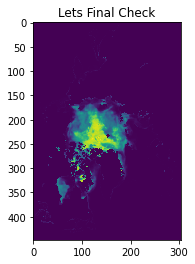

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/result/sub_0514_0_KNN(2019~2014,6models).csv', index = False)

# 시험용

In [ ]:
# train 데이터 셋
train = data[:12]
print(train.shape)

# 데이터 셋 형태 변환
data = data.reshape(24,1,448,304)

# test 데이터 생성
for i in tqdm(range(1)):
  globals()['test{}'.format(i)] = np.array(np.concatenate((data[15], data[16]), axis=0))

  # print("\n",globals()['train{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열

100%|██████████| 1/1 [00:00<00:00, 257.32it/s]

(12, 1, 448, 304)


In [ ]:
train = train.reshape(12,448,304)
train.shape, test0.shape

((12, 448, 304), (2, 448, 304))

In [ ]:

# 훈련데이터 12개만
x_train = train.reshape( 12,-1).T
y_train = test0.reshape(2,-1).T
x_test = train.reshape( 12,-1).T
real = test0.reshape(2,-1).T 

# K값을 찾아 1
from sklearn.neighbors import KNeighborsRegressor

num = [601]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(2,-1)
  
  print( "MAE : %s" % mae_score(real.reshape(2,-1)[0], fun1(pre)[0]),
      '\n F1 : %s' % f1_score(real.reshape(2,-1)[0], fun1(pre)[0]),
      '\n Final %s' % mae_over_f1(real.reshape(2,-1)[0], fun1(pre)[0]))
  

  0%|          | 0/1 [00:00<?, ?it/s]

601


100%|██████████| 1/1 [07:57<00:00, 477.33s/it]

MAE : 8.091517857142858e-05 
 F1 : 0.9999999785183193 
 Final 8.091517950047082e-05


In [ ]:
pre.reshape(448*304, 2).shape

(136192, 2)

In [ ]:
# 그래프를 보자구
plt.imshow(pre.reshape(448*304, 2)[:,0].reshape(448,304), interpolation = 'None')
plt.show() 

2018년 데이터

In [ ]:
# 1차 데이터 불러오기
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train.csv')

In [ ]:
# 데이터 불러오기
# 2000년도 데이터부터 불러옵니다.
dm = fn.iloc[2061:2084,1]
print(dm.shape,'\n', dm.head(), '\n', dm.tail())

(23,) 
 2061    12061.npy
2062    12062.npy
2063    12063.npy
2064    12064.npy
2065    12065.npy
Name: week_file_nm, dtype: object 
 2079    12079.npy
2080    12080.npy
2081    12081.npy
2082    12082.npy
2083    12083.npy
Name: week_file_nm, dtype: object


In [ ]:
# 데이터 생성
# 2000년도 이후 데이터들을 불러와 하나의 데이터 셋으로 만듭니다.
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12060.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape


100%|██████████| 23/23 [00:06<00:00,  3.60it/s]


(24, 448, 304)

In [ ]:
# train 데이터 셋
train1 = data[:12]
print('\n train1 :', train1.shape)

# 데이터 셋 형태 변환
data1 = data.reshape(24,1,448,304)
# test 데이터 생성
for i in tqdm(range(12)):
  globals()['test_1{}'.format(i)] = data1[12+i]

  print("\n test_1{} :".format(i) ,globals()['test_1{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열


100%|██████████| 12/12 [00:00<00:00, 9585.15it/s]


 train1 : (12, 448, 304)

 test_10 : (1, 448, 304)

 test_11 : (1, 448, 304)

 test_12 : (1, 448, 304)

 test_13 : (1, 448, 304)

 test_14 : (1, 448, 304)

 test_15 : (1, 448, 304)

 test_16 : (1, 448, 304)

 test_17 : (1, 448, 304)

 test_18 : (1, 448, 304)

 test_19 : (1, 448, 304)

 test_110 : (1, 448, 304)

 test_111 : (1, 448, 304)


추론 데이터

In [ ]:
# 1차 데이터 불러오기
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/public_weekly_test.csv')
fn.tail()

week_start week_file_nm                                          data_list
19  2020-05-18    12169.npy  20200518.npy,20200519.npy,20200520.npy,2020052...
20  2020-05-25    12170.npy  20200525.npy,20200526.npy,20200527.npy,2020052...
21  2020-06-01    12171.npy  20200601.npy,20200602.npy,20200603.npy,2020060...
22  2020-06-08    12172.npy  20200608.npy,20200609.npy,20200610.npy,2020061...
23  2020-06-15    12173.npy  20200615.npy,20200616.npy,20200617.npy,2020061...

In [ ]:
# 데이터 불러오기
# 2000년도 데이터부터 불러옵니다.
dm = fn.iloc[13:24,1]
print(dm.shape,'\n', dm.head(), '\n', dm.tail())

(11,) 
 13    12163.npy
14    12164.npy
15    12165.npy
16    12166.npy
17    12167.npy
Name: week_file_nm, dtype: object 
 19    12169.npy
20    12170.npy
21    12171.npy
22    12172.npy
23    12173.npy
Name: week_file_nm, dtype: object


In [ ]:
# 데이터 생성
# 2000년도 이후 데이터들을 불러와 하나의 데이터 셋으로 만듭니다.
data = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/12162.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/북극해빙/data/weekly_train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape


100%|██████████| 11/11 [00:02<00:00,  3.89it/s]


(12, 448, 304)

In [ ]:
# train 데이터 셋
inference = data[:12]
print('\n inference :', inference.shape)


 inference : (12, 448, 304)


In [ ]:
# 데이터 셋 형태 변환
# data = data.reshape(24,1,448,304)

# 월별로 데이터 셋 생성
# for i in tqdm(range(12)):
#   globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[1+i], data[2+i], data[3+i], data[4+i], data[5+i], data[6+i], data[7+i], data[8+i], data[9+i], data[10+i],
#                                                             data[11+i], data[12+i]), axis=0))

#   print("\n",globals()['train{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열

## 함수

In [ ]:
# 그림을 그리는 함수
# 코드공유 - 'DATA loading + Simple EDA + 참고가능 논문' 내의 함수를 약간 변경하였습니다.
# 코드 공유를 해주신 Jay윤님 감사합니다.

def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛 모양
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 둘째 자리에서 반올림하는 함수

def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 점수 계산
# 대회안내 - 규칙에 존재하는 산식 코드입니다.

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

# 테스팅
> 예측에는 아무 필요없는 섹션이기에, 실제 코딩시(Private Score 복원) 넘기셔도 무방합니다.

> 테스팅을 통해 얻고자 하는 것
* 1. 훈련을 시킬 데이터의 양 (몇 개의 데이터를 훈련시킬 것인가?)
* 2. KNeighborsRegressor에 들어갈 파라미터 값인 n_neighbors를 몇으로 할 것인가?

> 코드 설명 
* 코드 중 real이 train*[18]은 2019 예측을 의미합니다.
* 코드 중 real이 train*[19]는 2020 예측를 의미합니다.

1. 훈련시킬 데이터의 양

In [ ]:
# 이미지 EDA (날짜는 오름차순입니다. '2000->2001->2002...')
# 가운데에 빈 공간이 작은 12개까지를 기준 훈련데이터 양으로 잡았습니다.
# 12개가 기준인 이유는 크게 없습니다. 
# 그저 EDA를 통해서 가운데 빈공간이 작은 것들이 예측에 도움이 될 것이라 생각했습니다.
# 실제로 빈공간이 있는 데이터들까지 훈련하면 예측된 값들도 가운데 빈공간이 큽니다.(예측값의 손실이 발생)

show(train)

2. n_neighbors의 값

* 사실 n_neighbors의 값은 데이터 사이언티스트의 직감에 맞겨야합니다.
* 최적의 값을 찾으려고 여러가지 노력을 하였지만..... 종속변수를 모르는 상태로 예측을 해야하기 때문에 여러 번의 제출로 그 값을 예상해야합니다.

In [ ]:
train0[:12].shape

(12, 448, 304)

In [ ]:
train0[12]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:

from sklearn import svm

# 훈련데이터 12개만
x_train = train1.reshape( 12,-1).T
y_train = test_15.reshape(1,-1).T  # 변동없음
x_test = train[:12].reshape( 12,-1).T
real = test5.reshape(1,-1).T  # 변동없음

# K값을 찾아 1
from sklearn.neighbors import KNeighborsRegressor

num = ['rbf', 'linear', 'poly']

for i in tqdm(num):
  print(i)
  model = svm.SVR(kernel=i)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))
  



  0%|          | 0/3 [00:00<?, ?it/s]

rbf




 33%|███▎      | 1/3 [05:44<11:29, 344.75s/it]

MAE : 4.198392636865601 
 F1 : 0.6627511425019149 
 Final 6.334794924183056
linear


In [ ]:
# 그래프를 보자구
plt.imshow(pre.reshape(448,304), interpolation = 'None')
plt.show() 

In [ ]:
test_141 = test_14.reshape(1,448,304)
test_151 = test_15.reshape(1,448,304)

In [ ]:
data12 = np.concatenate((test_141,test_151), axis=0)

In [ ]:
data12

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [ ]:
test41 = test4.reshape(1,448,304)
test51 = test5.reshape(1,448,304)

In [ ]:
data12222 = np.concatenate((test_141,test_151), axis=0)

In [ ]:
data12.shape

(2, 448, 304)

In [ ]:
data12222.shape

(2, 448, 304)

In [ ]:
# n_neighbors의 값을 찾기 위한 노력 1

# 훈련데이터 12개만
x_train = train1.reshape( 12,-1).T
y_train = data12.reshape(2,-1).T  # 변동없음
x_test = train[:12].reshape( 12,-1).T
real = data12222.reshape(2,-1).T  # 변동없음

# K값을 찾아 1
from sklearn.neighbors import KNeighborsRegressor

num = [601]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))



  0%|          | 0/1 [00:00<?, ?it/s]

601




100%|██████████| 1/1 [07:51<00:00, 471.95s/it]

MAE : 5.494967509104795 
 F1 : 0.6718435259567413 
 Final 8.178939314017013


In [ ]:
pre.reshape(2,-1)[0].reshape(448,304)

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [197.33631219, 165.84088289, 194.65262201, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 184.76166112,
        198.44237926, 181.10907447],
       [202.76762975, 180.72160515, 201.73523449, ...,   0.        ,
          0.        ,   0.        ]])

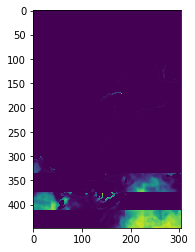

In [ ]:

# 그래프를 보자구
plt.imshow(pre.reshape(2,-1)[0].reshape(448,304), interpolation = 'None')
plt.show()

In [ ]:
# n_neighbors의 값을 찾기 위한 노력 1

# 훈련데이터 12개만
x_train = train1.reshape( 12,-1).T
y_train = test_15.reshape(1,-1).T  # 변동없음
x_test = train[:12].reshape( 12,-1).T
real = test5.reshape(1,-1).T  # 변동없음

# K값을 찾아 1
from sklearn.neighbors import KNeighborsRegressor

num = [601, 700]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))


  0%|          | 0/2 [00:00<?, ?it/s]

601



 50%|█████     | 1/2 [07:44<07:44, 464.16s/it]

MAE : 4.410117848331766 
 F1 : 0.6798917776952154 
 Final 6.486499657955497
700



100%|██████████| 2/2 [15:43<00:00, 471.58s/it]

MAE : 4.407753392269737 
 F1 : 0.6804556187953866 
 Final 6.477649982957449


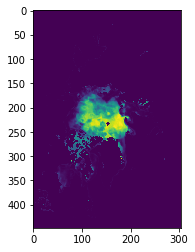

In [ ]:

# 그래프를 보자구
plt.imshow(pre.reshape(448,304), interpolation = 'None')
plt.show()

In [ ]:
pd.DataFrame(pre.reshape(448,304))

0    1    2    3    4    5    6    ...  297  298  299  300  301  302  303
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
443  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
444  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
445  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
446  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
447  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[448 rows x 304 columns]

600일때 4.317515622617064

In [ ]:
# n_neighbors의 값을 찾기 위한 노력 2

# 600, 650, 700을 찾아서

for j in tqdm(range(12)):
  print(j)
  dataset = globals()['train{}'.format(j)]

  # 훈련데이터 12개만
  x_train = dataset[6:18].reshape( 12,-1).T
  y_train = dataset[18].reshape(1,-1).T  # 변동없음
  x_test = dataset[7:19].reshape( 12,-1).T
  real = dataset[19]  # 변동없음

  # K값을 찾아 2
  from sklearn.neighbors import KNeighborsRegressor

  num = [500, 550, 600, 601, 650, 700, 750, 800, 850, 900, 950]

  for i in num:
    print(i)
    model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
    model.fit(x_train, y_train)

    pre = model.predict(x_test)
    pre = pre.reshape(-1)
  
    print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
           '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
           '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/12 [00:00<?, ?it/s]

0
500
MAE : 1.879193711818609 
 F1 : 0.8510191017234283 
 Final 2.2081686367924083
550
MAE : 1.8646010044642858 
 F1 : 0.8533053315587829 
 Final 2.1851509813100547
600
MAE : 1.8508407248590226 
 F1 : 0.8547474124343063 
 Final 2.1653656697645944
601
MAE : 1.8504875469924813 
 F1 : 0.8549874066845191 
 Final 2.1643447738310875
650
MAE : 1.838792733787594 
 F1 : 0.854140375125327 
 Final 2.1527991953193855
700
MAE : 1.8272760514567667 
 F1 : 0.8544956632693841 
 Final 2.1384263356951
750
MAE : 1.8174374412593983 
 F1 : 0.8526738332527227 
 Final 2.1314567763992387
800
MAE : 1.8085444078947366 
 F1 : 0.8508474375705153 
 Final 2.1255801061151454
850
MAE : 1.8006691288768792 
 F1 : 0.8501165794807638 
 Final 2.1181437359982542
900
MAE : 1.7933976298167293 
 F1 : 0.8482142656553895 
 Final 2.1143214412785323
950


  8%|▊         | 1/12 [1:05:22<11:59:05, 3922.32s/it]

MAE : 1.786857377819549 
 F1 : 0.8481362951438401 
 Final 2.1068044923704874
1
500
MAE : 2.9068139832001885 
 F1 : 0.7494524560476388 
 Final 3.87858351915199
550
MAE : 2.898486768679511 
 F1 : 0.7474747287135975 
 Final 3.8777053170623534
600
MAE : 2.8918575246710523 
 F1 : 0.7445963641246098 
 Final 3.883792112298271
601
MAE : 2.8917368861607144 
 F1 : 0.7445963641246098 
 Final 3.883630093633488
650
MAE : 2.88666368068609 
 F1 : 0.7431476381812262 
 Final 3.8843743739899983
700
MAE : 2.8830461407424814 
 F1 : 0.7420854361898911 
 Final 3.8850595380154416
750
MAE : 2.8800980968045113 
 F1 : 0.7390628282527095 
 Final 3.896959700495335
800
MAE : 2.8782762570488725 
 F1 : 0.7372408994622339 
 Final 3.9041190201292206
850
MAE : 2.8770624559445483 
 F1 : 0.7362784283809285 
 Final 3.9075739638270406
900
MAE : 2.876420347744361 
 F1 : 0.7338258151591268 
 Final 3.9197589525015992
950


 17%|█▋        | 2/12 [2:10:17<10:52:20, 3914.05s/it]

MAE : 2.875877070606203 
 F1 : 0.7312696089267523 
 Final 3.932717832346137
2
500
MAE : 4.186001380404136 
 F1 : 0.754346473626989 
 Final 5.549175970539871
550
MAE : 4.179774656367481 
 F1 : 0.7533319478623943 
 Final 5.548383568151997
600
MAE : 4.174298270089286 
 F1 : 0.7515923381835166 
 Final 5.553939286606529
601
MAE : 4.174209351503761 
 F1 : 0.7510791181904586 
 Final 5.557615961929999
650
MAE : 4.169387922932331 
 F1 : 0.7481420128787358 
 Final 5.572989880837284
700
MAE : 4.164271469689849 
 F1 : 0.7463737900232622 
 Final 5.579337685165344
750
MAE : 4.160175560972745 
 F1 : 0.7434511249500125 
 Final 5.595761934309863
800
MAE : 4.155705327772556 
 F1 : 0.738821544414613 
 Final 5.624775431822947
850
MAE : 4.151248384633459 
 F1 : 0.737018406991323 
 Final 5.632489350238763
900
MAE : 4.147874104205827 
 F1 : 0.7350714701619108 
 Final 5.642817353343914
950


 25%|██▌       | 3/12 [3:15:16<9:46:25, 3909.54s/it] 

MAE : 4.144565906954887 
 F1 : 0.7314502345037391 
 Final 5.666230803937752
3
500
MAE : 2.8488362018327074 
 F1 : 0.7602338987219138 
 Final 3.747315358008825
550
MAE : 2.8562502202772557 
 F1 : 0.7605236462649564 
 Final 3.755636260290338
600
MAE : 2.8642340225563916 
 F1 : 0.7608695458249622 
 Final 3.764421904686258
601
MAE : 2.864374779722745 
 F1 : 0.7608695458249622 
 Final 3.764606899821463
650
MAE : 2.871776095512218 
 F1 : 0.7599677615289743 
 Final 3.7788130011546537
700
MAE : 2.880160288416353 
 F1 : 0.758162012080222 
 Final 3.7988717510722263
750


In [ ]:
# n_neighbors의 값을 찾기 위한 노력 3

# 훈련데이터 12개만
x_train = train1.reshape( 12,-1).T
y_train = test_15.reshape(1,-1).T  # 변동없음
x_test = train[:12].reshape( 12,-1).T
real = test5.reshape(1,-1).T  # 변동없음

# K값을 찾아 3
from sklearn.neighbors import KNeighborsRegressor

num = [580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

In [ ]:
# n_neighbors의 값을 찾기 위한 노력 4

# # 훈련데이터 12개만
# x_train = train1[6:18].reshape( 12,-1).T
# y_train = train1[18].reshape(1,-1).T  # 변동없음
# x_test = train1[7:19].reshape( 12,-1).T
# real = train1[19]  # 변동없음

# 훈련데이터 12개만
x_train = train0[:12].reshape( 12,-1).T
y_train = train0[12].reshape(1,-1).T  # 변동없음
x_test = train1[:12].reshape( 12,-1).T
real = train1[12]  # 변동없음

# K값을 찾아 4
from sklearn.neighbors import KNeighborsRegressor

num = [594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/12 [00:00<?, ?it/s]

594


  8%|▊         | 1/12 [07:50<1:26:18, 470.77s/it]

MAE : 2.0221739162359023 
 F1 : 0.8370165564442766 
 Final 2.415930576889634
595


 17%|█▋        | 2/12 [15:35<1:18:09, 468.96s/it]

MAE : 2.022305274906015 
 F1 : 0.8367593530772122 
 Final 2.4168301714233777
596


 25%|██▌       | 3/12 [23:20<1:10:10, 467.82s/it]

MAE : 2.0225757019501875 
 F1 : 0.8368157304349206 
 Final 2.4169905084469234
597


 33%|███▎      | 4/12 [31:13<1:02:34, 469.28s/it]

MAE : 2.022767049459586 
 F1 : 0.8369602581935399 
 Final 2.4168017602859955
598


 42%|████▏     | 5/12 [39:09<54:58, 471.23s/it]  

MAE : 2.0228789503054516 
 F1 : 0.8370165564442766 
 Final 2.416772894829104
599


 50%|█████     | 6/12 [46:59<47:05, 470.89s/it]

MAE : 2.0228500205592104 
 F1 : 0.8366712525822949 
 Final 2.417735747629127
600


 58%|█████▊    | 7/12 [54:43<39:05, 469.05s/it]

MAE : 2.0230843955592106 
 F1 : 0.8368157304349206 
 Final 2.417598400464775
601


KeyboardInterrupt: ignored

600일때 4.317515622617064 - 2018년

600일때 5.005742495791236 - 2019년 (10)

900일때 4.9909113043175575 단, F1은 0.0805 - 2019년 (10)

900일때 2.1143214412785323 단, F1은 0.08482 - 2019년 (10)

500일때 5.549175970539871 - 2019년 (2)

400일때 3.9107814685121696 - 2019년 (4)

800일때 4.005349103136658 - 2019년 (6)

700일때 2.1384263356951 - 2019년 (0)

In [ ]:
# n_neighbors의 값을 찾기 위한 노력 5

# 월별 최적의 K값 찾기
# 일단은 모두 12개로 한정 
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# 저장
jj = pd.DataFrame(('데이터 셋', '데이터 빼기', 'K값', 'MAE', 'F1', 'Final')).T

for i in tqdm(range(10)):
    i = i+2
    dataset = globals()['train{}'.format(i)]
    print('\n << 데이터셋: %s >>' % i)

    datanum = [9, 10, 13]
    for j in datanum:
        print('! 데이터 뺴기: %s !' % j)
        x_train = dataset[j:17].reshape( (17-j),-1).T
        y_train = dataset[17].reshape(1,-1).T  # 변동없음
        x_test = dataset[(1+j):18].reshape( (17-j),-1).T
        real = dataset[18]  # 변동없음

        num = [500, 800, 1000]
        for k in tqdm(num):
            print('K값: %s' % k)
            model = KNeighborsRegressor(n_neighbors= k, weights='distance', p=1, n_jobs=-1)
            model.fit(x_train, y_train)

            pre = model.predict(x_test)
            pre = pre.reshape(-1)
            
            mae = mae_score(real.reshape(-1), fun1(pre))
            f1 = f1_score(real.reshape(-1), fun1(pre))
            finall = mae_over_f1(real.reshape(-1), fun1(pre))
            
            print( "MAE : %s" % mae,
                   '\n F1 : %s' % f1,
                   '\n Final %s' % finall)
            
            # 저장
            li = []
            li.append(i)
            li.append(j)
            li.append(k)
            li.append(mae)
            li.append(f1)
            li.append(finall)
            
            li1 = pd.DataFrame(li).T
            
            jj = jj.append(li1)
            jj = jj.reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]


 << 데이터셋: 2 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [05:32<11:04, 332.17s/it]

MAE : 3.9389819519501876 
 F1 : 0.703315490912971 
 Final 5.6005902711329565
K값: 800



 67%|██████▋   | 2/3 [11:44<05:44, 344.13s/it]

MAE : 3.93756013569079 
 F1 : 0.6921723662338903 
 Final 5.688698756103289
K값: 1000



100%|██████████| 3/3 [18:17<00:00, 365.79s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.9359186295817667 
 F1 : 0.6871657581077051 
 Final 5.7277571326353645
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [05:20<10:40, 320.21s/it]

MAE : 4.016891153665414 
 F1 : 0.6929371061639444 
 Final 5.796905750846002
K값: 800



 67%|██████▋   | 2/3 [11:05<05:27, 327.86s/it]

MAE : 4.009656954887219 
 F1 : 0.6854006415228903 
 Final 5.850092126376259
K값: 1000



100%|██████████| 3/3 [17:22<00:00, 347.48s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.006140889332706 
 F1 : 0.6817878413980829 
 Final 5.875934693053949
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [04:18<08:36, 258.38s/it]

MAE : 4.6006264685150375 
 F1 : 0.6802602868192941 
 Final 6.763038339921165
K값: 800



 67%|██████▋   | 2/3 [09:11<04:28, 268.87s/it]

MAE : 4.598022644501879 
 F1 : 0.6729339578119327 
 Final 6.832799151828378
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.595102208646616 
 F1 : 0.6676922908993987 
 Final 6.882065589878593

 << 데이터셋: 3 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [05:38<11:17, 338.90s/it]

MAE : 3.863840901080827 
 F1 : 0.6874095322625721 
 Final 5.620871785345312
K값: 800



 67%|██████▋   | 2/3 [11:51<05:49, 349.10s/it]

MAE : 3.822268268327067 
 F1 : 0.6801955798848276 
 Final 5.619366436901278
K값: 1000



100%|██████████| 3/3 [18:32<00:00, 370.79s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.8065781396851497 
 F1 : 0.6732526358572738 
 Final 5.65401140731963
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [05:21<10:42, 321.23s/it]

MAE : 3.861869346217105 
 F1 : 0.693200644351883 
 Final 5.57106996649882
K값: 800



 67%|██████▋   | 2/3 [11:07<05:28, 328.63s/it]

MAE : 3.825747694431391 
 F1 : 0.6869315271912041 
 Final 5.56932894662909
K값: 1000



100%|██████████| 3/3 [17:22<00:00, 347.64s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.812125675516917 
 F1 : 0.679199788248733 
 Final 5.612671978622791
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [04:15<08:30, 255.13s/it]

MAE : 4.112434357377819 
 F1 : 0.6762058436673242 
 Final 6.081630815637734
K값: 800



 67%|██████▋   | 2/3 [09:02<04:24, 264.94s/it]

MAE : 4.051854954769737 
 F1 : 0.6720967933832099 
 Final 6.0286776166371485
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.024410097509398 
 F1 : 0.6713417300940232 
 Final 5.994577511217712

 << 데이터셋: 4 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [05:48<11:36, 348.03s/it]

MAE : 3.5963952361372176 
 F1 : 0.7497440940390485 
 Final 4.796830300848765
K값: 800



 67%|██████▋   | 2/3 [12:04<05:56, 356.43s/it]

MAE : 3.5618042910009398 
 F1 : 0.7479295858934027 
 Final 4.762218677476401
K값: 1000



100%|██████████| 3/3 [18:47<00:00, 375.92s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.5473646763392854 
 F1 : 0.7423648970316606 
 Final 4.778464933806463
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [05:26<10:53, 326.92s/it]

MAE : 3.5639738016917293 
 F1 : 0.7643215874215389 
 Final 4.662924368112714
K값: 800



 67%|██████▋   | 2/3 [11:30<05:37, 337.89s/it]

MAE : 3.528751027960526 
 F1 : 0.7587965116504516 
 Final 4.650457569685705
K값: 1000



100%|██████████| 3/3 [18:05<00:00, 361.87s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.514265301926692 
 F1 : 0.7530800614214961 
 Final 4.666522771334591
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [04:34<09:08, 274.32s/it]

MAE : 3.5862483846334587 
 F1 : 0.7739845295244508 
 Final 4.633488398666089
K값: 800



 67%|██████▋   | 2/3 [09:38<04:43, 283.30s/it]

MAE : 3.5378494331531956 
 F1 : 0.7792272746347606 
 Final 4.540202201481505
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.5139734345629696 
 F1 : 0.7755617059133267 
 Final 4.530875315866771

 << 데이터셋: 5 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [06:05<12:11, 365.71s/it]

MAE : 4.316062690906955 
 F1 : 0.7913969327335874 
 Final 5.453726768262102
K값: 800



 67%|██████▋   | 2/3 [12:48<06:16, 376.79s/it]

MAE : 4.260973111489661 
 F1 : 0.7808393200690296 
 Final 5.456914050567832
K값: 1000



100%|██████████| 3/3 [19:52<00:00, 397.63s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.238583690671993 
 F1 : 0.7764054328285901 
 Final 5.45924005276166
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [05:48<11:36, 348.01s/it]

MAE : 4.319542117011279 
 F1 : 0.8012486805350794 
 Final 5.391013012609929
K값: 800



 67%|██████▋   | 2/3 [12:08<05:57, 357.61s/it]

MAE : 4.272029781484963 
 F1 : 0.7918160537998988 
 Final 5.395229999481994
K값: 1000



100%|██████████| 3/3 [18:57<00:00, 379.06s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.2538700511043235 
 F1 : 0.7864118708423063 
 Final 5.409213867099907
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [04:44<09:29, 284.67s/it]

MAE : 4.599858508576127 
 F1 : 0.7999173879612544 
 Final 5.750416880917659
K값: 800



 67%|██████▋   | 2/3 [09:57<04:53, 293.23s/it]

MAE : 4.532676074953009 
 F1 : 0.7995023657531041 
 Final 5.669371614666412
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 4.505597024788533 
 F1 : 0.7991666479514691 
 Final 5.637869122740783

 << 데이터셋: 6 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [06:26<12:52, 386.30s/it]

MAE : 3.395016227091166 
 F1 : 0.6925953457644551 
 Final 4.9018755306897805
K값: 800



 67%|██████▋   | 2/3 [13:32<06:38, 398.39s/it]

MAE : 3.331393987899436 
 F1 : 0.684202552971027 
 Final 4.86901711305122
K값: 1000



100%|██████████| 3/3 [21:05<00:00, 421.93s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.3058377144031943 
 F1 : 0.6776205521025686 
 Final 4.878597107717052
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [06:02<12:04, 362.43s/it]

MAE : 3.4276403900375936 
 F1 : 0.7087192888935773 
 Final 4.836386416157541
K값: 800



 67%|██████▋   | 2/3 [12:38<06:12, 372.66s/it]

MAE : 3.3561293614896615 
 F1 : 0.6969244380172299 
 Final 4.815628682618246
K값: 1000



100%|██████████| 3/3 [19:43<00:00, 394.51s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.3254798372885332 
 F1 : 0.6911167724077859 
 Final 4.811748060440486
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [05:00<10:01, 300.61s/it]

MAE : 3.5794379258693607 
 F1 : 0.7467559476782137 
 Final 4.79331686485424
K값: 800



 67%|██████▋   | 2/3 [10:31<05:09, 309.70s/it]

MAE : 3.5323800223214286 
 F1 : 0.7384180619366676 
 Final 4.78371285396221
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.5136861930216163 
 F1 : 0.7277149635611126 
 Final 4.828382430867407

 << 데이터셋: 7 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [06:45<13:30, 405.08s/it]

MAE : 3.1803962787828945 
 F1 : 0.7345260931636814 
 Final 4.329861478148417
K값: 800



 67%|██████▋   | 2/3 [14:08<06:56, 416.65s/it]

MAE : 3.130996607730263 
 F1 : 0.7198624902718057 
 Final 4.349437019636474
K값: 1000



100%|██████████| 3/3 [21:56<00:00, 438.72s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.110869214050752 
 F1 : 0.708364339555202 
 Final 4.39162306234657
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [06:22<12:45, 382.69s/it]

MAE : 3.1797853031015038 
 F1 : 0.7184513410778588 
 Final 4.42588812496632
K값: 800



 67%|██████▋   | 2/3 [13:19<06:32, 392.86s/it]

MAE : 3.150234154722744 
 F1 : 0.7015445751632108 
 Final 4.490426155865572
K값: 1000



100%|██████████| 3/3 [20:46<00:00, 415.66s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.132823146734023 
 F1 : 0.6914199512518895 
 Final 4.530998990919661
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [05:14<10:28, 314.12s/it]

MAE : 3.592407483552632 
 F1 : 0.6718226161290805 
 Final 5.347255873550179
K값: 800



 67%|██████▋   | 2/3 [11:01<05:24, 324.22s/it]

MAE : 3.574509589403196 
 F1 : 0.6602597218398962 
 Final 5.413793113571198
K값: 1000



  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 3.5602359903665413 
 F1 : 0.6599011004843465 
 Final 5.395105317755021

 << 데이터셋: 8 >>
! 데이터 뺴기: 9 !
K값: 500



 33%|███▎      | 1/3 [06:54<13:48, 414.00s/it]

MAE : 2.4812607201597743 
 F1 : 0.6959152618086549 
 Final 3.5654638153163107
K값: 800



 67%|██████▋   | 2/3 [14:24<07:04, 424.87s/it]

MAE : 2.4290752026550755 
 F1 : 0.6899938431395659 
 Final 3.520430206156841
K값: 1000



100%|██████████| 3/3 [22:23<00:00, 447.83s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 2.411608391094925 
 F1 : 0.6882916098833721 
 Final 3.503759629535459
! 데이터 뺴기: 10 !
K값: 500



 33%|███▎      | 1/3 [06:31<13:03, 391.77s/it]

MAE : 2.5005953359962407 
 F1 : 0.7020826863392894 
 Final 3.561682048332095
K값: 800



 67%|██████▋   | 2/3 [13:38<06:42, 402.16s/it]

MAE : 2.445425061677632 
 F1 : 0.6941643570397731 
 Final 3.5228328877006705
K값: 1000



100%|██████████| 3/3 [21:14<00:00, 424.87s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

MAE : 2.4284330210291345 
 F1 : 0.6907407225369764 
 Final 3.5156939595988526
! 데이터 뺴기: 13 !
K값: 500



 33%|███▎      | 1/3 [05:24<10:48, 324.28s/it]

MAE : 2.6763267299107136 
 F1 : 0.7031345851734014 
 Final 3.806279406933034
K값: 800



 67%|██████▋   | 2/3 [11:20<05:33, 333.75s/it]

MAE : 2.62732891799812 
 F1 : 0.6947040314552929 
 Final 3.7819398783031253
K값: 1000


In [ ]:
# n_neighbors의 값을 찾기 위한 노력 6

##### 600, 601 차이 구하기 #####
from sklearn.neighbors import KNeighborsRegressor

for i in range(12):
  dataset = globals()['train{}'.format(i)]
  print('\n << 데이터셋 : %s >>' % i)

  # 훈련데이터 12개만
  x_train = dataset[5:17].reshape( 12,-1).T
  y_train = dataset[17].reshape(1,-1).T  # 변동없음
  x_test = dataset[6:18].reshape( 12,-1).T
  real = dataset[18]  # 변동없음

  num = [602, 603]
  for j in tqdm(num):
    print('!! K값: %s !!' % j)
    model = KNeighborsRegressor(n_neighbors= j, weights='distance', p=1, n_jobs=-1)
    model.fit(x_train, y_train)

    pre = model.predict(x_test)
    pre = pre.reshape(-1)
  
    print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
           '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
          '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/1 [00:00<?, ?it/s]


 << 데이터셋 : 0 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 2.945055142739661 
 F1 : 0.7941236293074737 
 Final 3.7085599734922083

 << 데이터셋 : 1 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 3.708133884515978 
 F1 : 0.7175103921330618 
 Final 5.168055924335306

 << 데이터셋 : 2 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 4.051990865836467 
 F1 : 0.6739275224246629 
 Final 6.012502340211826

 << 데이터셋 : 3 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 3.9349540354793224 
 F1 : 0.6986399235325111 
 Final 5.632306208983986

 << 데이터셋 : 4 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 3.614608714168234 
 F1 : 0.7409113979093296 
 Final 4.878597731903971

 << 데이터셋 : 5 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 4.247626072015977 
 F1 : 0.7961690423483867 
 Final 5.335080608178808

 << 데이터셋 : 6 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 3.455910699600564 
 F1 : 0.6994841392709029 
 Final 4.940656201005815

 << 데이터셋 : 7 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 3.2364753436325193 
 F1 : 0.7275811735183046 
 Final 4.448266965869239

 << 데이터셋 : 8 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 2.3863516212406015 
 F1 : 0.697135874572757 
 Final 3.4230795947379584

 << 데이터셋 : 9 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 4.168980703712407 
 F1 : 0.7162576517508872 
 Final 5.820504165388417

 << 데이터셋 : 10 >>
!! K값: 604 !!


  0%|          | 0/1 [00:00<?, ?it/s]

MAE : 2.895823396381579 
 F1 : 0.6703560921835418 
 Final 4.319828501521882

 << 데이터셋 : 11 >>
!! K값: 604 !!


100%|██████████| 1/1 [07:26<00:00, 446.18s/it]

MAE : 2.179491893796993 
 F1 : 0.8334545241949283 
 Final 2.6150099428066143


In [ ]:
# n_neighbors의 값을 찾기 위한 노력 7

# 월별 최적의 K값 찾기
# 일단은 모두 12개로 한정 
from sklearn.neighbors import KNeighborsRegressor

# 일단은 6개만 찾자
for i in tqdm(range(6)):
  dataset = globals()['train{}'.format(i)]
  print('\n << 데이터셋 : %s >>' % i)

  # 훈련데이터 12개만
  x_train = dataset[5:17].reshape( 12,-1).T
  y_train = dataset[17].reshape(1,-1).T  # 변동없음
  x_test = dataset[6:18].reshape( 12,-1).T
  real = dataset[18]  # 변동없음

  num = [200, 300, 400, 500, 600, 700]
  for j in tqdm(num):
    print('K값: %s' % j)
    model = KNeighborsRegressor(n_neighbors= j, weights='distance', p=1, n_jobs=-1)
    model.fit(x_train, y_train)

    pre = model.predict(x_test)
    pre = pre.reshape(-1)
  
    print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
           '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
          '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/6 [00:00<?, ?it/s]


 << 데이터셋 : 0 >>
K값: 200



 17%|█▋        | 1/6 [06:47<33:54, 407.00s/it]

MAE : 3.0469034891917297 
 F1 : 0.8043130802414987 
 Final 3.7882057698164315
K값: 300



 33%|███▎      | 2/6 [13:41<27:17, 409.26s/it]

MAE : 2.9941048666588346 
 F1 : 0.7997589689449932 
 Final 3.7437589892501433
K값: 400



 50%|█████     | 3/6 [20:45<20:40, 413.57s/it]

MAE : 2.9638983200187967 
 F1 : 0.7954774695878553 
 Final 3.725936178047959
K값: 500



 67%|██████▋   | 4/6 [27:58<13:59, 419.50s/it]

MAE : 2.956448543233083 
 F1 : 0.7953714792950415 
 Final 3.7170662803785692
K값: 600



 83%|████████▎ | 5/6 [35:19<07:05, 425.95s/it]

MAE : 2.9454232994595877 
 F1 : 0.7946155225747291 
 Final 3.7067275666205117
K값: 700



  0%|          | 0/6 [00:00<?, ?it/s]

MAE : 2.9341060414708657 
 F1 : 0.7906211245842669 
 Final 3.7111404098926717

 << 데이터셋 : 1 >>
K값: 200



 17%|█▋        | 1/6 [06:40<33:23, 400.76s/it]

MAE : 3.7326413445723685 
 F1 : 0.7556025190919106 
 Final 4.939953481969267
K값: 300



 33%|███▎      | 2/6 [13:34<26:58, 404.64s/it]

MAE : 3.7101306978383457 
 F1 : 0.7474402551598923 
 Final 4.963782218830122
K값: 400



 50%|█████     | 3/6 [20:30<20:24, 408.02s/it]

MAE : 3.704859536536655 
 F1 : 0.7360034275095074 
 Final 5.03375303391677
K값: 500



 67%|██████▋   | 4/6 [27:51<13:56, 418.02s/it]

MAE : 3.7045947632753755 
 F1 : 0.7256906500868712 
 Final 5.104922754320559
K값: 600


최종적으로 예상된 훈련데이터 수는 '12개'이며, n_neighbors의 값은 '601'입니다. ๑•‿•๑

# KNeighborsRegressor 모델

## 추론

In [ ]:
train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
test0

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)


  0%|          | 0/12 [00:00<?, ?it/s]

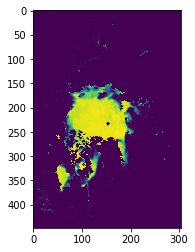


  8%|▊         | 1/12 [07:45<1:25:21, 465.63s/it]

(136192,)


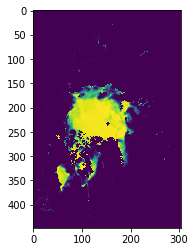


 17%|█▋        | 2/12 [15:22<1:17:11, 463.11s/it]

(136192,)


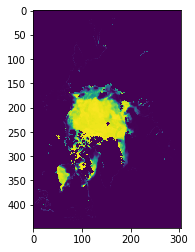


 25%|██▌       | 3/12 [23:00<1:09:11, 461.33s/it]

(136192,)



 33%|███▎      | 4/12 [30:38<1:01:22, 460.34s/it]

(136192,)


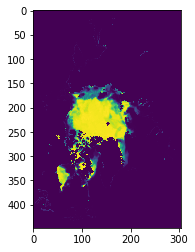


 42%|████▏     | 5/12 [38:14<53:34, 459.23s/it]  

(136192,)


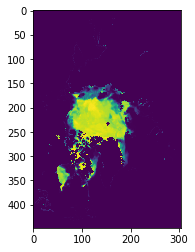


 50%|█████     | 6/12 [46:00<46:06, 461.14s/it]

(136192,)


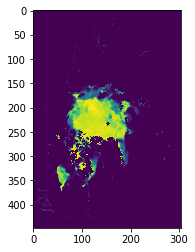


 58%|█████▊    | 7/12 [53:37<38:19, 459.81s/it]

(136192,)



 67%|██████▋   | 8/12 [1:01:14<30:36, 459.24s/it]

(136192,)



 75%|███████▌  | 9/12 [1:08:50<22:54, 458.13s/it]

(136192,)


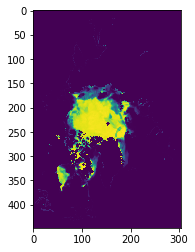


 83%|████████▎ | 10/12 [1:16:31<15:18, 459.00s/it]

(136192,)


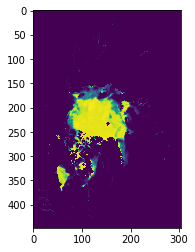


 92%|█████████▏| 11/12 [1:24:17<07:41, 461.02s/it]

(136192,)


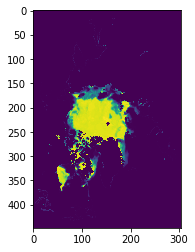


100%|██████████| 12/12 [1:31:57<00:00, 459.76s/it]

(136192,)


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['test{}'.format(i)]

  # 데이터셋 나누기
  x_train = train.reshape(12,-1).T
  y_train = datan.reshape(1,-1).T
  x_test = inference.reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

## 2019년 가져오기

In [ ]:
# 배포된 2차 데이터
# 2019년 데이터 가져오기
dm1 = fn.iloc[483:,1]
dm1.shape

(11,)

In [ ]:
# 2019년 데이터 전처리
data1 = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data2/train_data_v2/201901.npy')
data1 = data1.reshape(1,448,304,5)

for i in tqdm(dm1):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data2/train_data_v2/'+i)
    a = a.reshape(1,448,304,5)

    data1 = np.concatenate((data1,a), axis=0)
data1 = np.array(data1)
data1 = data1[:,:,:,0]
sh1 = data1.reshape(12, -1)
sh1 = pd.DataFrame(sh1)

sh1.shape

100%|██████████| 11/11 [00:00<00:00, 214.61it/s]


(12, 136192)

In [ ]:
# 2019년 데이터 확인
sh1

0       1       2       3       ...  136188  136189  136190  136191
0        0       0       0       0  ...       0       0       0       0
1        0       0       0       0  ...       0       0       0       0
2        0       0       0       0  ...       0       0       0       0
3        0       0       0       0  ...       0       0       0       0
4        0       0       0       0  ...       0       0       0       0
5        0       0       0       0  ...       0       0       0       0
6        0       0       0       0  ...       0       0       0       0
7        0       0       0       0  ...       0       0       0       0
8        0       0       0       0  ...       0       0       0       0
9        0       0       0       0  ...       0       0       0       0
10       0       0       0       0  ...       0       0       0       0
11       0       0       0       0  ...       0       0       0       0

[12 rows x 136192 columns]

## 2020년 예측

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [07:06<1:18:14, 426.74s/it]

(136192,)


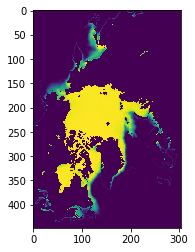

 17%|█▋        | 2/12 [13:57<1:10:18, 421.81s/it]

(136192,)


 25%|██▌       | 3/12 [20:45<1:02:38, 417.66s/it]

(136192,)


 33%|███▎      | 4/12 [27:39<55:32, 416.59s/it]  

(136192,)


 42%|████▏     | 5/12 [34:48<49:03, 420.53s/it]

(136192,)


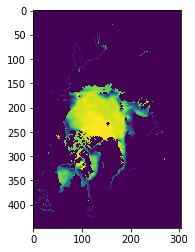

 50%|█████     | 6/12 [42:21<43:00, 430.06s/it]

(136192,)


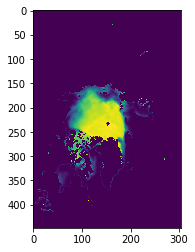

 58%|█████▊    | 7/12 [50:23<37:09, 445.83s/it]

(136192,)


 67%|██████▋   | 8/12 [58:50<30:56, 464.13s/it]

(136192,)


 75%|███████▌  | 9/12 [1:07:23<23:56, 478.77s/it]

(136192,)


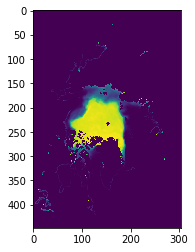

 83%|████████▎ | 10/12 [1:15:21<15:57, 478.60s/it]

(136192,)


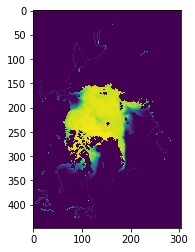

 92%|█████████▏| 11/12 [1:22:52<07:50, 470.28s/it]

(136192,)


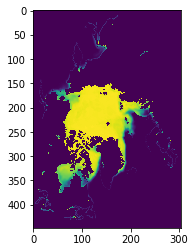

100%|██████████| 12/12 [1:30:01<00:00, 450.10s/it]

(136192,)


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[7:19].reshape(12,-1).T
  y_train = datan[19].reshape(1,-1).T
  x_test = datan[8:20].reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) #601
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(pred_0.reshape(1,-1))  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred_{}'.format(i+1)] = globals()['pred_{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred_{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2 = pd.concat((sh2, sh), axis=0)
  print(sh2.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


In [ ]:
# 1차 데이터 확인 (Pre-제출본)
sh2

0       1       2       3       ...  136188  136189  136190  136191
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0

[12 rows x 136192 columns]

# 제출

In [ ]:
# 제출 데이터 인덱스 수정

# 2019 데이터와 2020 예측 합치기
result = pd.concat([sh2,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/북극해빙/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'week_start'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

week_start    0    1    2    3  ...  136187  136188  136189  136190  136191
19  2021-08-24  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
20  2021-08-31  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
21  2021-09-07  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
22  2021-09-14  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
23  2021-09-21  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0

[5 rows x 136193 columns]

Text(0.5, 1.0, 'Lets Final Check')

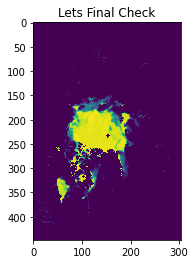

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/북극해빙/result/sub_0512_0_KNN(12, 601).csv', index = False)

수고하셨습니다. ( ⁎ ᵕᴗᵕ ⁎ )

 --------------------

---------------------------

> 부록) 2019 예측
* ᕕ( ՞ ᗜ ՞ )ᕗ 혹시 2019년 예측을 보고 싶은 분들을 위한 2019 예측 코드입니다.
* 모델 부분에 넣으셔서 실행하시면 됩니다.
* 리더보드 'public' 점수 3.857051597이 나오실 것입니다.

In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[6:18].reshape(12,-1).T 
  y_train = datan[18].reshape(1,-1).T
  x_test = datan[7:19].reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) 
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

-------------

* 코드 공유는 여기까지 입니다.
* 대회 초부터 많은 코드를 작성하였지만 가장 결과가 좋은 모델이자 코드들입니다. 
* (나머지 코드들은 제 깃허브에 가시면 난잡하게 업로드 되어 있을 것입니다 (；☉_☉)

> 정말 수고하셨습니다. ( ´╹ᗜ╹`*)
* 궁금한 사항 있으시면 댓글을 통해 답변드리겠습니다.